In [1]:
import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [2]:
resolution = 64

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=64,
    test_resolutions=[64]
)

Loading test db for resolution 64 with 50 samples 


In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = TFNO(
    n_modes=(16, 16), 
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    factorization='tucker',
    implementation='factorized',
    rank=0.05
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

/home/jaeminseo/anaconda3/envs/PINN/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Our model has 270145 parameters.


In [4]:
n_epochs = 100
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [ ]:
import wandb
from datetime import datetime

wandb.init(
    project='Samsung_Project',
    name=f'TFNO_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tjwoals217 (tjwoals217-Chung-Ang University) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
trainer = Trainer(model=model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([100, 1, 64, 64])
[0] time=1.08, avg_loss=1.0016, train_err=100.1557
Eval: 64_h1=0.9831, 64_l2=0.5606
[1] time=0.69, avg_loss=0.9911, train_err=99.1123
Eval: 64_h1=0.9623, 64_l2=0.5514
[2] time=0.72, avg_loss=0.9308, train_err=93.0823
Eval: 64_h1=0.8114, 64_l2=0.4446
[3] time=0.69, avg_loss=0.7152, train_err=71.5212
Eval: 64_h1=0.5321, 64_l2=0.2278
[4] time=0.69, avg_loss=0.4826, train_err=48.2623
Eval: 64_h1=0.3976, 64_l2=0.2448
[5] time=0.67, avg_loss=0.3831, train_err=38.3082
Eval: 64_h1=0.3452, 64_l2=0.2424
[6] time=0.67, avg_loss=0.3426, train_err=34.2600
Eval: 64_h1=0.3165, 64_l2=0.2016
[7] time=0.66, avg_loss=0.3106, train_err=31.0612
Eval: 64_h1=0.2852, 64_l2=0.1309
[8] time=0.64, avg_loss=0.2824, train_err=28.2442
Eval: 64_h1=0.2601, 64_l2=0.1026
[9] time=0.65, avg_loss=0.2599, train_err=25.9933
Eval: 64_h1=0.2413, 64_l2=0.0888
[10] time=0.68, avg_loss=0.2417, train_er

{'train_err': 9.546631308810905,
 'avg_loss': 0.09546631308810904,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.6679477859288454,
 '64_h1': tensor(0.0953, device='cuda:0', dtype=torch.float64),
 '64_l2': tensor(0.0283, device='cuda:0', dtype=torch.float64)}

In [8]:
wandb.finish()

L2 error (0) : 0.009755880858740944
L2 error (1) : 0.019706406622101953
L2 error (2) : 0.01802830367390065


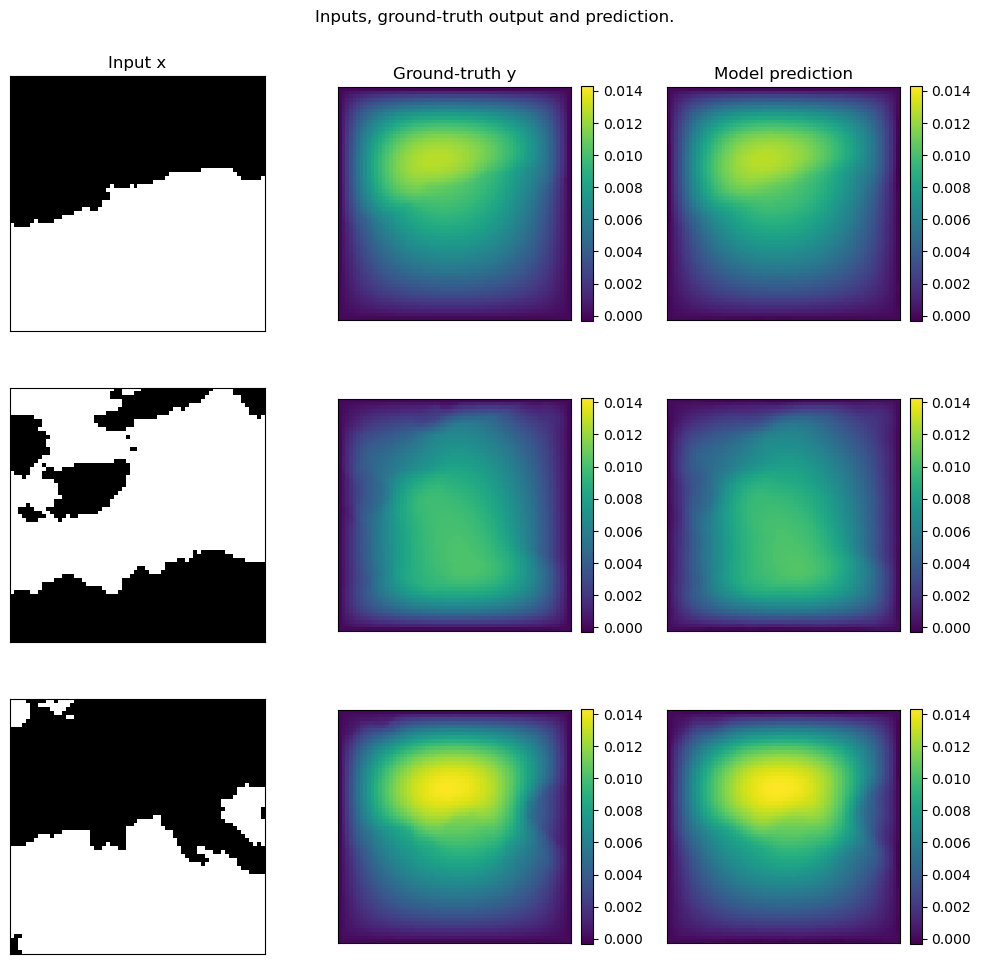

In [11]:
test_samples = test_loaders[64].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = model(x.unsqueeze(0))

    y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = model(x.unsqueeze(0)).squeeze().detach()

    # y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()